# Huấn luyện và Đánh giá mô hình XGBoost

Notebook này tập trung vào việc xây dựng, tối ưu và đánh giá mô hình XGBoost cho bài toán phân loại thời tiết.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.utils import compute_sample_weight

# Cấu hình hiển thị
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

## 1. Chuẩn bị Dữ liệu

In [11]:
# Đọc dữ liệu đã tiền xử lý
data = pd.read_csv('preprocessed_data.csv')

# Tách features và label
X = data.drop(columns=['weather_group'])
y = data['weather_group']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Các lớp:", le.classes_)

Các lớp: ['Cloudy' 'Drizzle' 'Rain']


In [3]:
data.columns

Index(['temperature_2m', 'relative_humidity_2m', 'surface_pressure',
       'cloud_cover', 'wind_speed_10m', 'weather_group', 'temperature_2m_lag1',
       'surface_pressure_lag1', 'humidity_change', 'hour_sin', 'hour_cos',
       'dew_point_gap', 'pressure_trend_6h', 'humidity_roll_mean_3h',
       'month_sin', 'month_cos', 'temp_humidity_interaction',
       'pressure_humidity_interaction'],
      dtype='object')

In [12]:
# Chia tập dữ liệu (Train - Val - Test) theo thứ tự thời gian
# Lưu ý: shuffle=False để giữ tính chất chuỗi thời gian
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42, shuffle=False)

print(f"Kích thước tập Train: {X_train.shape}")
print(f"Kích thước tập Val: {X_val.shape}")
print(f"Kích thước tập Test: {X_test.shape}")

Kích thước tập Train: (12285, 15)
Kích thước tập Val: (1755, 15)
Kích thước tập Test: (3511, 15)


In [5]:
# Chuẩn hóa dữ liệu (RobustScaler tốt cho dữ liệu có ngoại lệ)
numeric_features = ['temperature_2m', 'relative_humidity_2m',
       'surface_pressure', 'cloud_cover', 'wind_speed_10m',
       'humidity_change', 'temperature_2m_lag1',
       'surface_pressure_lag1',
       'dew_point_gap',
       'pressure_trend_6h', 'humidity_roll_mean_3h']

scaler = RobustScaler()

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

# Fit trên train và transform cho val/test
X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_val_scaled[numeric_features] = scaler.transform(X_val[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

### Feature Engineering (Thêm biến tương tác)
Thêm các biến tương tác giữa nhiệt độ, độ ẩm và áp suất để mô hình nắm bắt tốt hơn các mối quan hệ phi tuyến.

In [6]:
X_train_scaled.columns

Index(['temperature_2m', 'relative_humidity_2m', 'surface_pressure',
       'cloud_cover', 'wind_speed_10m', 'temperature_2m_lag1',
       'surface_pressure_lag1', 'humidity_change', 'hour_sin', 'hour_cos',
       'dew_point_gap', 'pressure_trend_6h', 'humidity_roll_mean_3h',
       'month_sin', 'month_cos', 'temp_humidity_interaction',
       'pressure_humidity_interaction'],
      dtype='object')

## 2. Tìm kiếm siêu tham số cho XGBoost (Hyperparameter Tuning)

Để tối ưu hóa mô hình XGBoost, chúng tôi sử dụng **Grid Search** kết hợp với **Time Series Cross Validation**.

**Tại sao dùng TimeSeriesSplit?**
Dữ liệu thời tiết có tính phụ thuộc thời gian. Cross-validation ngẫu nhiên (k-fold thông thường) có thể dùng dữ liệu tương lai để train cho quá khứ, dẫn đến kết quả ảo. TimeSeriesSplit đảm bảo các fold huấn luyện luôn nằm trước fold kiểm thử về mặt thời gian.

**Các siêu tham số quan trọng:**
1.  `n_estimators`: Số lượng cây quyết định (Boosting rounds). Nhiều cây hơn có thể học kỹ hơn nhưng dễ gây overfitting và chậm.
2.  `learning_rate`: Tốc độ học (Shrinkage). Giá trị nhỏ giúp mô hình hội tụ tốt hơn nhưng cần nhiều cây hơn.
3.  `max_depth`: Độ sâu tối đa của mỗi cây. Cây càng sâu càng dễ bắt được các tương tác phức tạp nhưng cũng dễ overfitting.
4.  `subsample`: Tỷ lệ mẫu dùng để xây dựng mỗi cây (giúp giảm overfitting).


In [7]:
# Gộp tập Train và Val để Grid Search có cái nhìn tổng quan hơn (nhưng vẫn CV đúng cách)
X_train_val = pd.concat([X_train_scaled, X_val_scaled])
y_train_val = np.concatenate([y_train, y_val])

# Tính toán sample weights xử lý mất cân bằng
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_val)

# Khởi tạo TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Khởi tạo XGBoost Classifier
# objective='multi:softmax' cho bài toán đa lớp
xgb_clf = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# Định nghĩa lưới tham số
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    cv=tscv,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

print("Bắt đầu tìm kiếm tham số (có xử lý mất cân bằng dữ liệu)...")
start_time = time.time()
grid_search.fit(X_train_val, y_train_val, sample_weight=sample_weights)
end_time = time.time()

print(f"Thời gian tìm kiếm: {end_time - start_time:.2f} giây")
print("Best parameters:", grid_search.best_params_)
print("Best F1 Score (Validation):", grid_search.best_score_)

# Lấy mô hình tốt nhất
best_xgb = grid_search.best_estimator_

Bắt đầu tìm kiếm tham số (có xử lý mất cân bằng dữ liệu)...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Thời gian tìm kiếm: 242.84 giây
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best F1 Score (Validation): 0.5536582955493492


## 3. Kiểm thử Mô hình (Model Evaluation)

Đánh giá mô hình trên tập Test (hoàn toàn chưa được nhìn thấy trong quá trình training hay tuning).

=== KẾT QUẢ ĐÁNH GIÁ ===
Training Accuracy: 0.7976
Testing Accuracy:  0.6314
Macro F1-Score:    0.6231
Inference Time:    0.0952s cho 3513 mẫu

Classification Report:

              precision    recall  f1-score   support

      Cloudy       0.87      0.54      0.67      1675
     Drizzle       0.56      0.70      0.62      1366
        Rain       0.47      0.77      0.58       472

    accuracy                           0.63      3513
   macro avg       0.63      0.67      0.62      3513
weighted avg       0.70      0.63      0.64      3513



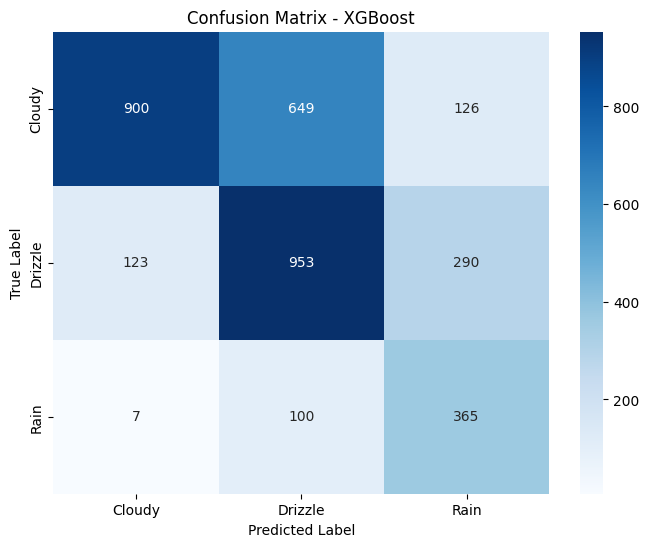

In [8]:
# Đo thời gian huấn luyện lại (nếu cần) và thời gian dự đoán
# Note: best_xgb đã được fit trên X_train_val ở cuối quá trình GridSearch (refit=True mặc định)

# Đo Inference Time (trên tập Test)
start_inf = time.time()
y_pred = best_xgb.predict(X_test_scaled)
end_inf = time.time()
inference_time = end_inf - start_inf

# Tính các chỉ số
train_acc = best_xgb.score(X_train_val, y_train_val)
test_acc = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred, average='macro')

print("=== KẾT QUẢ ĐÁNH GIÁ ===")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy:  {test_acc:.4f}")
print(f"Macro F1-Score:    {test_f1:.4f}")
print(f"Inference Time:    {inference_time:.4f}s cho {len(y_test)} mẫu")

print("\nClassification Report:\n")
# Chuyển target_names sang string để tránh lỗi
target_names_str = [str(c) for c in le.classes_]
print(classification_report(y_test, y_pred, target_names=target_names_str))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names_str, yticklabels=target_names_str)
plt.title('Confusion Matrix - XGBoost')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Feature Importance
Xem xét các đặc trưng nào ảnh hưởng nhiều nhất đến quyết định của mô hình.

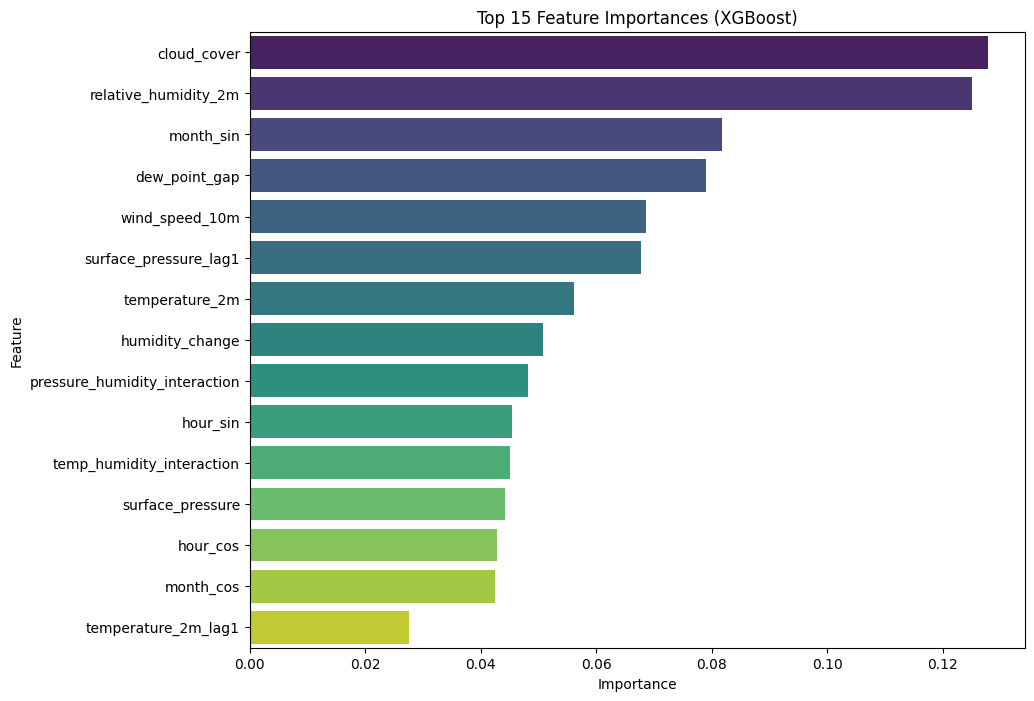

In [9]:
feature_importances = best_xgb.feature_importances_
feature_names = X_train_scaled.columns

# Tạo DataFrame để sort và vẽ
fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
fi_df = fi_df.sort_values(by='Importance', ascending=False).head(15) # Top 15

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')
plt.title('Top 15 Feature Importances (XGBoost)')
plt.show()